# Notebook 4: The Geometry Bridge – Understanding GALE

---

## Learning Objectives

By the end of this notebook, you will:

1. **Understand** the fundamental challenges of building AI surrogates for industrial CFD
2. **Recognize** why standard deep learning architectures struggle to maintain geometric awareness
3. **Visualize** representation drift and its impact on prediction accuracy
4. **Master** the GALE mechanism that makes GeoTransolver effective
5. **Connect** architectural innovations to practical aerodynamic applications

---

## 1. Introduction: The Challenge of AI for Industrial CFD

### 1.1 The Promise of AI Surrogates

Computer-Aided Engineering (CAE) is undergoing a transformation. Traditional high-fidelity CFD simulations—while accurate—can take **hours to days** per design iteration. This creates a bottleneck in the design exploration process, where engineers need to evaluate hundreds or thousands of candidate geometries.

**AI-based surrogate models** promise to change this paradigm:

| Metric | Traditional CFD | AI Surrogate | Speedup |
|--------|-----------------|--------------|---------|
| Time per evaluation | Hours to days | Seconds to minutes | 100-1000× |
| Design iterations/week | ~10-50 | ~1000+ | 20-100× |
| Hardware requirements | HPC clusters | Single GPU | Significant reduction |

However, achieving this promise requires overcoming several fundamental challenges that have limited existing approaches.

---

### 1.2 Why Building Reliable Physics-AI Is Hard

Real-world engineering problems present a unique combination of difficulties:

#### **Challenge 1: Geometric Complexity**

Real-world geometries are **heterogeneous and irregular** with multiscale features. A car body includes smooth surfaces, sharp edges, complex wheel wells, mirrors, and underbody details—all of which influence the flow field differently.

```text
   Fine details          Medium features          Global shape
  ┌─────────┐          ┌─────────────┐          ┌─────────────────┐
  │ • Edges │          │ • Curvature │          │ • Overall form  │
  │ • Gaps  │    +     │ • Features  │    +     │ • Wake region   │
  │ • Seams │          │ • Openings  │          │ • Far-field     │
  └─────────┘          └─────────────┘          └─────────────────┘
       ↓                      ↓                          ↓
 Flow separation      Pressure gradients        Drag & lift forces
```

#### **Challenge 2: Nonlinear Physics with Long-Range Dependencies**

Local effects—such as boundary layer separation at a sharp edge—can produce **long-range dependencies** that span the entire computational domain. A small geometric change near the front of a vehicle can dramatically alter the wake structure meters downstream.

#### **Challenge 3: Regime Sensitivity**

Physical behavior changes dramatically with operating conditions:
- **Reynolds number**: Laminar vs. turbulent flow
- **Mach number**: Subsonic vs. transonic (shock formation)
- **Angle of attack**: Attached vs. separated flow

Models must **encode and respect** these physical regimes and boundary conditions efficiently.

#### **Challenge 4: Data Scarcity and Domain Shift**

High-fidelity simulations are expensive, making datasets inherently limited. Additionally:
- Training data may be biased by specific solver settings
- Domain shifts occur across different shape families (sedans vs. SUVs vs. aircraft)
- Generalization to unseen geometries remains difficult

#### **Challenge 5: Layer-wise Error Accumulation**

Deep neural networks can **accumulate error layer-by-layer**, particularly in stiff regimes where small perturbations grow rapidly. This manifests as "representation drift"—a phenomenon we will explore in detail in this notebook.

---

### 1.3 The Limitation of Existing Approaches

Let's briefly survey how current methods address (or fail to address) these challenges:

| Approach | Strengths | Limitations |
|----------|-----------|-------------|
| **FNO** (Fourier Neural Operator) | Efficient global mixing via spectral convolution | Struggles with irregular domains; requires structured grids |
| **GNO** (Graph Neural Operator) | Handles irregular meshes via message passing | Local interactions only; limited long-range coupling |
| **MeshGraphNet** | Respects mesh topology | Computational cost scales poorly with mesh size |
| **Transolver** | Physics-aware attention; handles unstructured data | Geometry context can fade in deep layers |
| **DoMINO** | Multi-scale ball queries; good generalization | Context not persistently maintained at depth |

> **The Gap:** While each approach excels in certain aspects, none fully addresses the combination of geometric complexity, long-range physics, regime sensitivity, AND deep network stability simultaneously.

---

### 1.4 Enter GeoTransolver

**GeoTransolver** is designed to address this gap. It extends the Transolver architecture with innovations specifically targeting the challenges outlined above:

| Challenge | GeoTransolver Solution |
|-----------|------------------------|
| Geometric complexity | Multi-scale ball queries capture features at all scales |
| Long-range dependencies | Transformer attention enables nonlocal coupling |
| Regime sensitivity | Global parameters injected as persistent context |
| Deep network stability | **GALE attention** maintains geometric awareness at every layer |

The key innovation is **GALE (Geometry-Aware Latent Embeddings)**—a novel attention mechanism that we will explore in depth in Section 3.

---

### 1.5 Key Contributions (Overview)

GeoTransolver introduces three architectural innovations:

| Contribution | What It Does | Problem It Solves |
|--------------|--------------|-------------------|
| **GALE Attention** | Pairs physics-aware self-attention with cross-attention to geometry context | Prevents "forgetting" of geometric features in deep layers |
| **Persistent Context Projection** | Injects geometry and global features into every transformer block | Reduces layer-wise drift; improves stability |
| **Multi-Scale Ball Queries** | Captures local and global geometric information at multiple radii | Balances boundary-layer fidelity with far-field coupling |

> **Section 3** will provide a detailed walkthrough of how GALE works. First, let's understand the broader context and visualize the problem it solves.

---

### 1.6 Notebook Roadmap

| Section | Topic | Focus |
|---------|-------|-------|
| **2** | Background & Related Work | Where GeoTransolver fits in the AI-for-science landscape |
| **3** | The GALE Mechanism | Detailed architecture walkthrough (Core of this notebook) |
| **4** | Representation Drift | Visualizing why GALE matters |
| **5** | Interactive Demonstration | Hands-on exploration with Ahmed Body geometry |
| **6** | Results Interpretation | Understanding visualization outputs |
| **7** | Summary & Next Steps | Connecting to training notebooks |

---

### 1.7 Prerequisites

Before proceeding, ensure familiarity with:

| Prerequisite | Notebooks |
|--------------|-----------|
| ✅ Transformer fundamentals (attention mechanisms) | General ML background |
| ✅ Transolver architecture | Notebooks 1-3 of this series |

---

> **Let's Begin:** In Section 2, we explore the landscape of neural operators and position GeoTransolver relative to state-of-the-art approaches. Then, in Section 3, we dive deep into the GALE mechanism—the heart of GeoTransolver's innovation.

---

*Reference: Content based on "GeoTransolver: Learning Physics on Irregular Domains using Multi-scale Geometry Aware Physics Attention Transformer" (ICML 2025)* — [GeoTransolver_ICML-komprimiert.pdf]




---

## 2. The Problem: Representation Drift in Deep Networks

### 2.1 What Happens Inside a Deep Transformer?

When data flows through a deep neural network, each layer transforms the input representation:

$$H^{(\ell)} = \text{Layer}_\ell\left(H^{(\ell-1)}\right)$$

Where $H^{(\ell)}$ is the hidden representation at layer $\ell$. Each layer applies attention, normalization, and feedforward operations to transform the features to solve the physics.

### 2.2 The "Telephone Game" Analogy

Representation drift is like the children's game of **"Telephone"**:

| Layer | What the Network "Remembers" |
| :--- | :--- |
| **Layer 0** | *"I am a point on the side mirror at position (x, y, z)"* |
| **Layer 10** | *"I am associated with a high-pressure region"* |
| **Layer 20** | *"I am a generic fluid particle"* |
| **Layer 30** | *"I am... something?"* ❌ (Geometric context is lost) |

> *"Since the inputs to each physics attention layer are the outputs of the previous layer only, there is no 'recall' ability for fine-grained attending to encode geometrical features."*
> — *GeoTransolver Paper (ICML 2025)*

### 2.3 Why Does This Matter for CFD?

In Computational Fluid Dynamics, geometric features directly determine flow physics:

| Geometric Feature | Physical Significance | Consequence if "Forgotten" |
| :--- | :--- | :--- |
| **Sharp edges** | Flow separation points | Incorrect wake prediction |
| **Surface curvature** | Pressure gradients | Wrong lift/drag estimates |
| **No-Slip Walls** | Boundary Conditions | Fluid passing through solid objects |

**Bottom line:** If the network forgets geometry in deep layers, it cannot enforce boundary conditions, making predictions unreliable.

---

## 3. GeoTransolver: The GALE Mechanism Simplified

### 3.1 The Core Idea: Persistent Geometry Conditioning

Standard neural networks for physics simulation face a fundamental limitation:

> *"Since the inputs to each physics attention layer are the outputs of the previous layer only, there is no 'recall' ability for fine-grained attending to encode geometrical features."*
> — GeoTransolver Paper (ICML 2025)

**GeoTransolver's Solution:** Instead of injecting geometry only at the input, GeoTransolver maintains a **persistent geometry context** that is accessible at **every layer** through a mechanism called **GALE (Geometry-Aware Latent Embeddings)**.

Think of GALE as the network's **"GPS system"**:
- In standard deep networks, the model can "get lost" as it processes many layers (Representation Drift)
- GALE ensures that no matter how deep the network goes, it always knows **exactly what shape** it is simulating


```mermaid
graph LR
    subgraph Standard ["STANDARD TRANSOLVER"]
    direction LR
    G(Geometry) --> I[Input]
    I --> L1(Layer 1)
    L1 --> L2(Layer 2)
    L2 --> Dots(...)
    Dots --> O[Output]
    
    style G fill:#f96,stroke:#333
    style I fill:#fff,stroke:#333
    end
```
```mermaid
graph TD
    subgraph Geo ["GEOTRANSOLVER (GALE)"]
    C[<b>Geometry Context - C</b><br/>Always-On GPS Signal]
    I[Input] --> L1(Layer 1)
    L1 --> L2(Layer 2)
    L2 --> L3(Layer 3)
    L3 --> O[Output]

    C -.->|GALE Recall| L1
    C -.->|GALE Recall| L2
    C -.->|GALE Recall| L3
    
    style C fill:#00c8ff,stroke:#000,color:#fff
    style I fill:#fff,stroke:#333
    end
```

<div align="center">
    <img src="./fig/fig1_gale_concept.png" width="40%" />
    <p style="margin-top: 10px; font-size: 0.95em;">
    </p>
</div>


---

### 3.2 The Geometry Context: What Does the Network "Remember"?

Before understanding how GALE works, we need to know what information is stored in the **Geometry Context (C)**:

| Component | Description | Why It Matters |
|-----------|-------------|----------------|
| **Multi-scale geometry features** | Surface details captured at multiple resolutions via ball queries | Captures both fine details (edges) and global shape |
| **Global parameters** | Reynolds number, Mach number, angle of attack | Defines the flow regime |
| **Boundary information** | Inlet/outlet conditions, wall types | Specifies physical constraints |

The context $C$ is built **once** at the beginning and then **reused** at every GALE layer—this is what makes it "persistent."

---

### 3.3 How GALE Works: The 3-Step Process

Think of each GALE layer as a specialist that performs three tasks in sequence:


#### **Step 1: Physics Evolution (Self-Attention)**

The model examines how physical quantities (pressure, velocity) evolve based on interactions between spatial locations:

$$SA^{(\ell)}_m = \text{Attention}\left(H^{(\ell-1)} W_Q,\ H^{(\ell-1)} W_K,\ H^{(\ell-1)} W_V\right)$$

**Intuition:** *"Based on the current flow state, how should pressure and velocity change at each point?"*

This is similar to standard Transolver—the network learns physical dynamics through attention.


#### **Step 2: Geometry Recall (Cross-Attention)**

The model "checks back" with the original blueprint by querying the persistent geometry context:

$$CA^{(\ell)}_m = \text{Attention}\left(H^{(\ell-1)} W_{Q,c},\ C \cdot W_{K,c},\ C \cdot W_{V,c}\right)$$

**Intuition:** *"Does my current physics prediction still respect the actual physical geometry? Where are the walls, edges, and curves?"*

| Attention Type | Query Source | Key/Value Source | Purpose |
|----------------|--------------|------------------|---------|
| Self-Attention | Current state $$H^{(\ell-1)}$$ | Current state $$H^{(\ell-1)}$$ | Physics evolution |
| Cross-Attention | Current state $$H^{(\ell-1)}$$ | Geometry context $$C$$ | Geometry recall |


#### **Step 3: Smart Mixing (Adaptive Gating)**

The model uses a **learned gate** $\alpha$ to blend the physics update with the geometry recall:

$$\alpha^{(\ell)} = \sigma\left(\eta\left(\text{Pool}(SA^{(\ell)}),\ \text{Pool}(C)\right)\right)$$

$$H^{(\ell)} = (1 - \alpha^{(\ell)}) \cdot SA^{(\ell)} + \alpha^{(\ell)} \cdot CA^{(\ell)}$$

Where:
- $\alpha^{(\ell)} \in (0, 1)$ = Learned mixing coefficient
- $\sigma$ = Sigmoid function (ensures output between 0 and 1)
- $\eta$ = Small MLP that learns when to emphasize geometry vs physics

**Intuition:** *"At this specific location and layer depth, should I trust my physics calculation more, or do I need to double-check the geometry?"*

---

### 3.4 The Key Insight: Why "Adaptive" Gating is Powerful
The gate $\alpha$ is **not a fixed number**—it's a **learned, spatially-varying switch** that adapts based on:

1. **Where** on the surface (complex vs simple regions)
2. **How deep** in the network (early vs late layers)
3. **What** the current physical state looks like

| Region Type | Gate (α) Behavior | Physical Reasoning |
| :--- | :--- | :--- |
| **Complex geometry**<br>(mirrors, spoilers) | **High α** | Sharp details create flow separation; model needs constant geometry reminders. |
| **Flat surfaces**<br>(roof, underbody) | **Low α** | Simple geometry; model can focus primarily on physics evolution. |
| **Wake regions**<br>(behind vehicle) | **Moderate α** | No surface nearby, but wake structure depends on upstream geometry. |

```mermaid
graph TD
    subgraph HighAlpha ["HIGH α (Geometry-focused)"]
        direction LR
        C1[<b>Complex Regions</b>] --- M(Side mirror, Spoiler)
        C1 --> R[<b>Action:</b> High Recall]
        R -.->|Pulls from| G(Geometry Blueprint)
        style HighAlpha fill:#fff4f4,stroke:#e66,stroke-width:2px
    end

    subgraph LowAlpha ["LOW α (Physics-focused)"]
        direction LR
        C2[<b>Simple Regions</b>] --- F(Flat roof, Hood)
        C2 --> P[<b>Action:</b> High Physics]
        P -.->|Trusts| L(Fluid Evolution)
        style LowAlpha fill:#f4f9ff,stroke:#66a,stroke-width:2px
    end
```

<div align="center">
    <img src="./fig/fig2_gate_behaviour.png" width="80%" />
    <p style="margin-top: 10px; font-size: 0.95em;">
    </p>
</div>


---

### 3.5 Why This Matters for Industrial CFD

The adaptive gating mechanism provides three critical benefits:

| Benefit | Explanation | Impact |
|---------|-------------|--------|
| **Bounded Error** | Continuous geometry re-injection prevents unbounded drift | More accurate predictions at all network depths |
| **Efficient Computation** | Low $$\alpha$$ regions skip heavy geometry processing | Faster inference without sacrificing accuracy |
| **Better Generalization** | Persistent conditioning improves extrapolation to new shapes | Works on car designs not seen during training |

> **The Result:** By re-injecting geometry at every layer with adaptive strength, GeoTransolver maintains a **bounded representation error**, making it significantly more accurate for industrial CFD applications than models that only process geometry once at the input.

---

### 3.6 Summary: The GALE Mechanism at a Glance

Each GALE layer acts as a specialized processing unit that balances physical simulation with geometric grounding.

```mermaid
graph LR
    In[Input: H ℓ-1] --> SA[Self-Attention<br/>Physics Evolution]
    In --> CA[Cross-Attention<br/>Geometry Recall]
    
    SA --> Gate{Gate α}
    CA --> Gate
    
    Gate --> Mix[H ℓ = 1-α SA + α CA]
    Mix --> Out[Output: H ℓ]
    
    style Gate fill:#f9f,stroke:#333
    style Mix fill:#dfd,stroke:#333
```

<div align="center">
    <img src="./fig/fig3_gale_layer.png" width="40%" />
    <p style="margin-top: 10px; font-size: 0.95em;">
    </p>
</div>

**Key Equations Summary:**

| Step | Equation | Purpose |
|------|----------|---------|
| Self-Attention | $$SA^{(\ell)} = \text{Attn}(H W_Q, H W_K, H W_V)$$ | Physics evolution |
| Cross-Attention | $$CA^{(\ell)} = \text{Attn}(H W_{Q,c}, C W_{K,c}, C W_{V,c})$$ | Geometry recall |
| Adaptive Gate | $$\alpha^{(\ell)} = \sigma(\eta(\text{Pool}(SA), \text{Pool}(C)))$$ | Smart mixing |
| Output | $$H^{(\ell)} = (1-\alpha) \cdot SA + \alpha \cdot CA$$ | Combined result |


---

## 4. Visualizing Representation Drift: A Demonstration

### 4.1 What We Will Show

To build intuition for **representation drift**, we construct a **simplified but realistic simulation** using actual neural network components (MLP layers) applied to the *Ahmed Body* geometry. The goal is **conceptual clarity**: to visually illustrate how geometric representations can progressively degrade—or remain stable—across network depth.

| Experiment | Method | Expected Outcome |
|------------|--------|------------------|
| **Case A** | Standard Network (No GALE) | Geometry becomes progressively **noisy/fuzzy** as depth increases |
| **Case B** | GALE Network (Context Injection) | Geometry remains **clean and sharp** throughout all layers |

**Key Point:** Both networks receive **identical noise and MLP transformations**. The *only* difference is GALE's persistent context injection at each layer.

To quantify drift, we compute:
- **Mean Squared Error (MSE):** Distance from original geometry
- **Noise Level (Std Dev):** Spread of point displacements

---

### 4.2 What Makes This Demonstration Realistic

Unlike a simple random noise simulation, this demonstration uses **actual neural network components**:

| Component | Implementation | Purpose |
|-----------|----------------|---------|
| **MLP Layers** | `nn.Linear` → `ReLU` → `nn.Linear` → `ReLU` → `nn.Linear` | Simulates learned transformations in real networks |
| **Random Noise** | `torch.randn_like(x) * noise_scale` | Represents accumulated perturbations from optimization |
| **Context Injection** | $(1-\alpha) \cdot \text{physics\_out} + \alpha \cdot \text{context}$ | Simplified GALE mechanism |

This provides a more faithful representation of what happens in deep networks while remaining interpretable.

---

### 4.3 ⚠️ Important: Simulation vs. Reality

> **This visualization is a pedagogical tool designed to build intuition. While it uses real neural network components, it does _not_ represent actual trained model behavior.**

| Aspect | Our Simulation | Real GeoTransolver Training |
|--------|----------------|----------------------------|
| **Network architecture** | Simple MLP blocks (3D → 64D → 3D) | Full transformer with attention (256-512D embeddings) |
| **Source of drift** | MLP perturbation + explicit Gaussian noise | Implicit drift from learned weight updates and attention operations |
| **Noise injection** | Deliberate ($\sigma = 0.04$ per layer) for visibility | Much smaller, accumulated changes during optimization |
| **GALE mechanism** | Fixed $\alpha$ blending: $(1-\alpha) \cdot x_{\text{noisy}} + \alpha \cdot C$ | Full cross-attention with learned Q, K, V projections and adaptive gating |
| **Representation space** | Raw 3D coordinates $(x, y, z)$ | High-dimensional latent embeddings |
| **Objective** | Build visual intuition | Enable accurate and stable physics predictions |

---

### 4.4 The Core Equations

#### Standard Network (No GALE)

Each layer applies an MLP transformation plus noise, with no mechanism to recall original geometry:

$x^{(\ell)} = x^{(\ell-1)} + \text{MLP}_\ell(x^{(\ell-1)}) + \epsilon^{(\ell)}$

Where $\epsilon^{(\ell)} \sim \mathcal{N}(0, \sigma^2)$ is random noise at layer $\ell$.

**Problem:** Errors accumulate across layers:

$x^{(L)} = x^{(0)} + \sum_{\ell=1}^{L} \left( \text{MLP}_\ell + \epsilon^{(\ell)} \right) \Rightarrow \text{Unbounded drift}$

#### GALE Network (Context Injection)

Each layer applies the **same** MLP and noise, but then blends with the original context:

$x^{(\ell)}_{\text{physics}} = x^{(\ell-1)} + \text{MLP}_\ell(x^{(\ell-1)}) + \epsilon^{(\ell)}$

$x^{(\ell)} = (1 - \alpha) \cdot x^{(\ell)}_{\text{physics}} + \alpha \cdot C$

Where:
- $C = x^{(0)}$ is the **persistent context** (original geometry)
- $\alpha \in (0, 1)$ is the context strength

**Solution:** The context term $\alpha \cdot C$ acts as a **stabilizing anchor**, preventing unbounded drift.

---

```mermaid
graph TD
    In["Input x<sup>(ℓ-1)</sup>"] --> MLP["MLP(x)<br/>x + MLP(x)"]
    MLP --> Noise["Add noise ε (σ = 0.04)"]
    
    Noise --> PathA["❌ NOISY PATH<br/>(No Injection)"]
    Noise --> PathB["✅ CLEAN PATH<br/>(Context Injection)"]

    PathB --> Context["(1-α)x + αC"]
    
    PathA --> OutA["Output x<sup>(ℓ)</sup>"]
    Context --> OutB["Output x<sup>(ℓ)</sup>"]

    OutA --> FinalA["<b>After 30 layers:</b><br/>Fuzzy/Degraded"]
    OutB --> FinalB["<b>After 30 layers:</b><br/>Preserved"]

    style PathA fill:#fee,stroke:#f66
    style PathB fill:#efe,stroke:#6b6

```

<div align="center">
    <img src="./fig/GALE_injection.png" width="15%" />
    <p style="margin-top: 10px; font-size: 0.95em;">
    </p>
</div>

As you see in above flowchart **GALE's improvement comes purely from context injection**, not from receiving less noise or simpler transformations.

---

## 5. Running the Demonstration

The following cell loads the Ahmed Body geometry and executes the MLP-based drift simulation for both networks.

**Implementation details** are contained in `utils/mlp_drift_demonstration.py`. Here, we focus on interpreting the **visual and quantitative results**.

### What the Code Does:

1. **Loads** Ahmed Body surface geometry from the validation dataset
2. **Creates** two networks with identical MLP architectures
3. **Runs** both networks for 30 layers with the same noise injection
4. **Records** intermediate outputs at each layer for visualization
5. **Computes** MSE and noise metrics to quantify drift

### Parameters:

| Parameter | Value | Meaning |
|-----------|-------|---------|
| `num_layers` | 30 | Number of network layers to simulate |
| `hidden_dim` | 64 | MLP hidden layer dimension |
| `noise_scale` | 0.04 | Per-layer noise standard deviation ($\sigma$) |
| `context_strength` | 0.6 | GALE's pull toward original ($\alpha$) |

---


✅ Loaded 1954 points

🧠 NOISY DRIFT COMPARISON (EDUCATIONAL VERSION)
   Geometry points:    1954
   Number of layers:   30
   Noise scale:        0.02
   Context strength:   0.6

📊 Results Summary:
   Layer 0 MSE:        0.000000
   Final MSE (Std):    0.2917
   Final MSE (GALE):   0.0009
   Improvement:        342.5×

📐 Noise Level (Std Dev of displacement):
   Final noise (Std):  0.2767
   Final noise (GALE): 0.0236



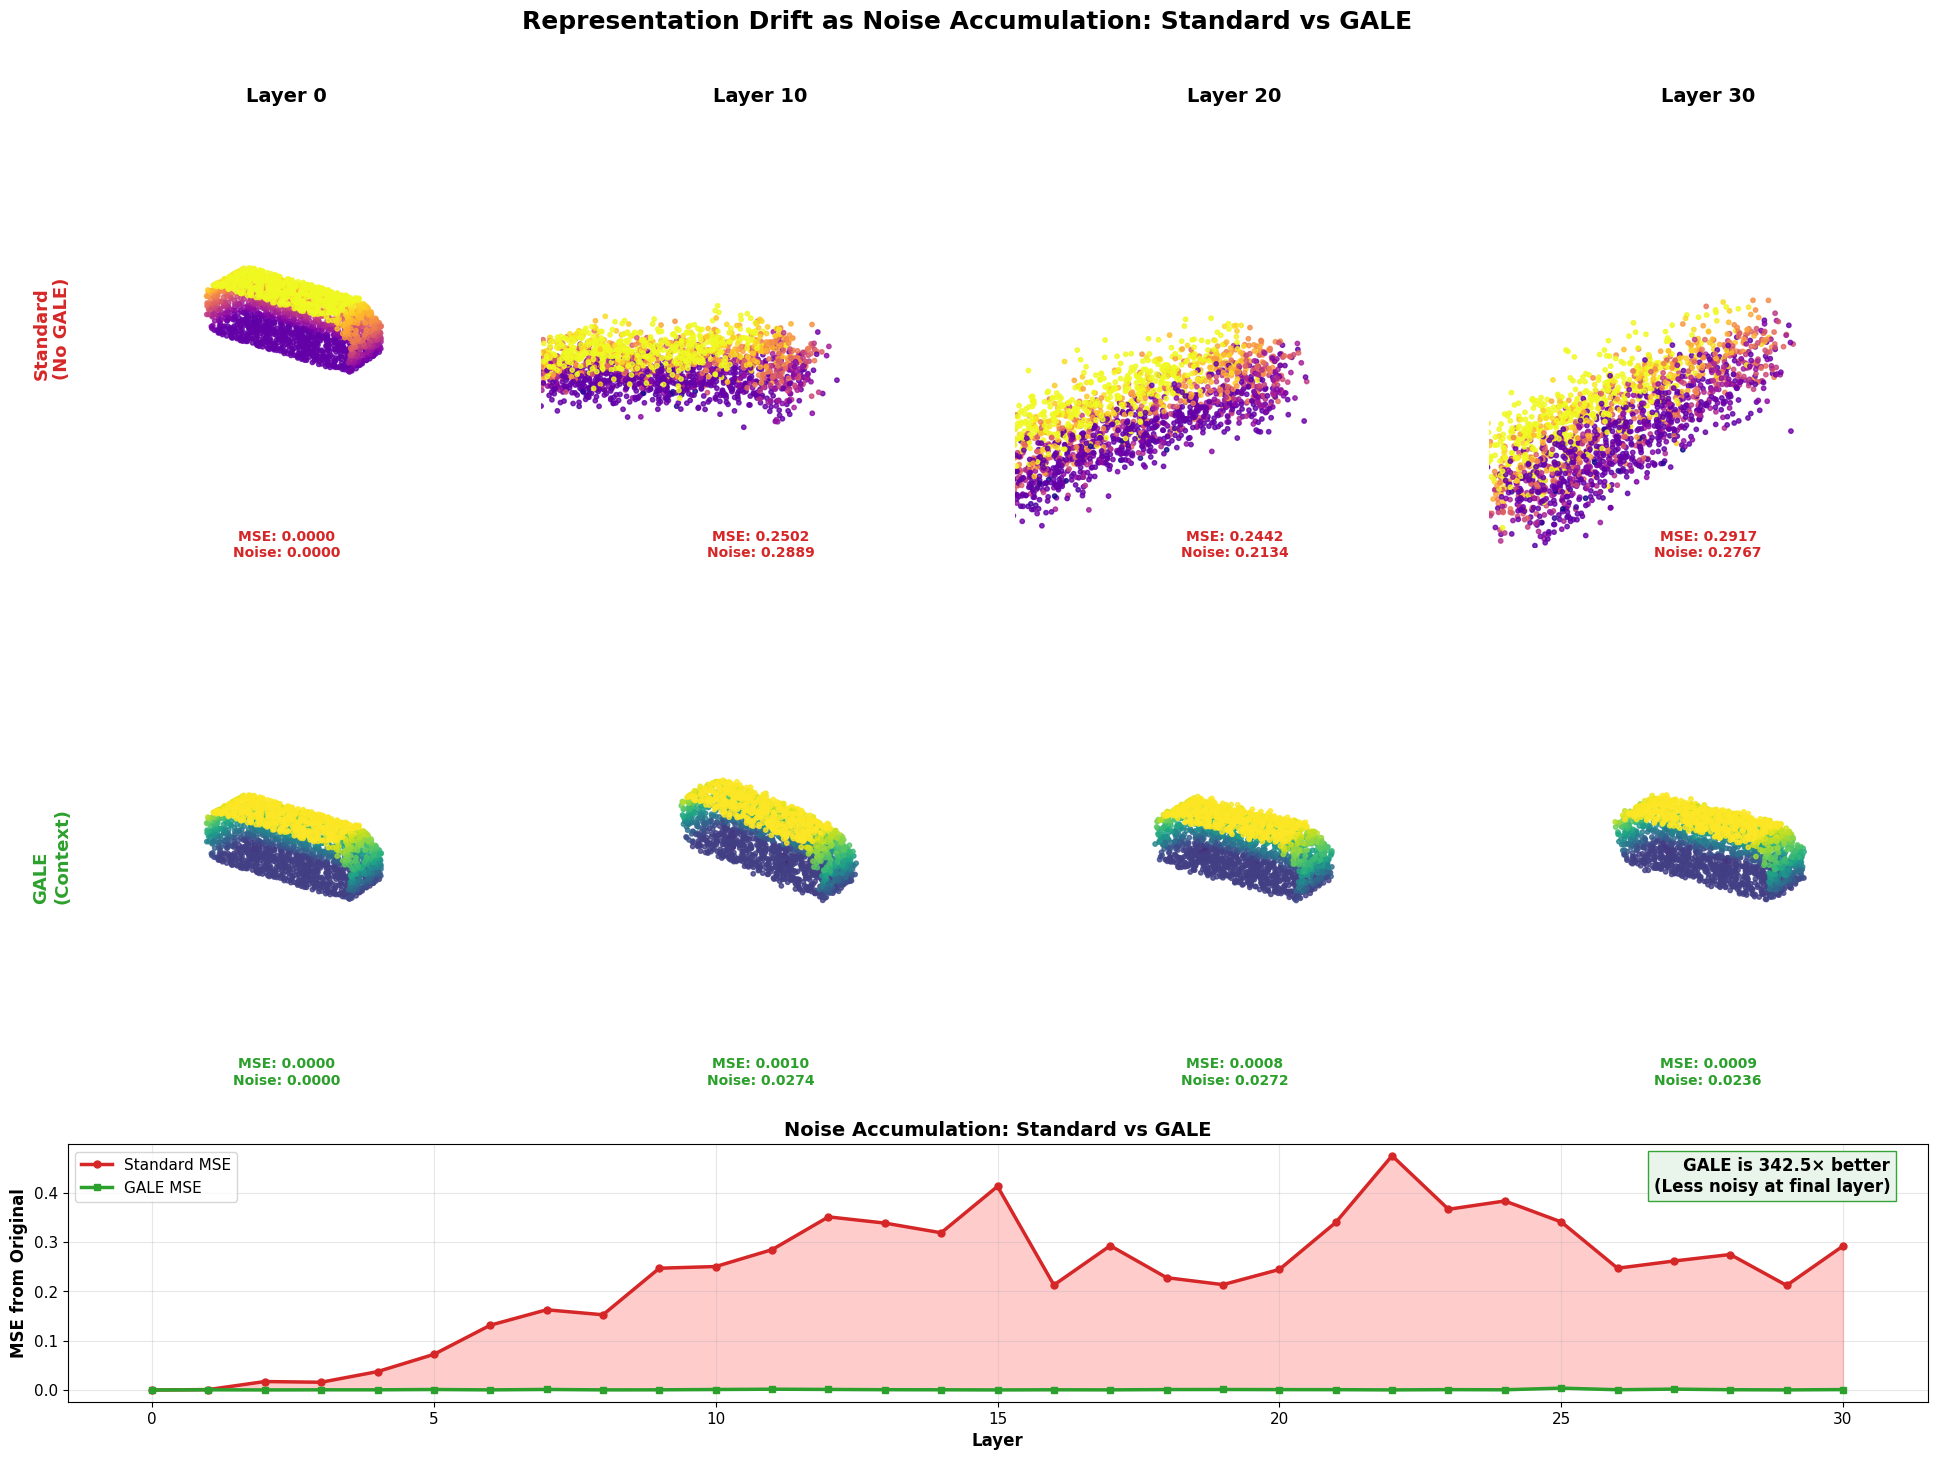

In [2]:
# You need to have these packges as mentioned in readme installed
# pip install hydra-core tabulate tensorboard termcolor torchinfo einops transformer_engine[pytorch] zarr>=3.0 zarrs
# Import visualization utilities
from utils.utils import load_ahmed_body_geometry, run_mlp_drift_comparison , plot_mlp_drift_comparison

geometry = load_ahmed_body_geometry("/workspace/DLI/val", 40)

# Parameters for visible noise accumulation
results = run_mlp_drift_comparison(
    geometry,
    num_layers=30,
    hidden_dim=64,
    noise_scale=0.02,      # Higher = more visible noise
    context_strength=0.6   # GALE correction strength
)

plot_mlp_drift_comparison(results, geometry, [0, 10, 20, 30])


### **5.1 Figure Interpretation: Understanding the Visualization**

#### What You're Seeing

The visualization above demonstrates **representation drift** through deep neural network layers, comparing two architectures:

| Row | Network | Observation |
|-----|---------|-------------|
| **Top** | Standard (No GALE) | Geometry becomes progressively **noisy/fuzzy** as layer depth increases |
| **Bottom** | GALE Network | Geometry remains **clean and sharp** throughout all layers |

---

#### Layer-by-Layer Analysis

| Layer | Standard Network | GALE Network |
|-------|------------------|--------------|
| **Layer 0** | Clean Ahmed Body shape | Clean Ahmed Body shape |
| **Layer 10** | Slight noise visible - points beginning to scatter | Shape remains crisp and well-defined |
| **Layer 20** | Moderate noise - original shape harder to distinguish | Shape still clearly recognizable |
| **Layer 30** | Heavy noise - geometry significantly degraded | Shape preserved almost perfectly |

---

#### Why Does Standard Network Get Noisy?

In the Standard network, **both MLP transformations and random noise** are applied at each layer:

$x^{(\ell)} = x^{(\ell-1)} + \text{MLP}(x^{(\ell-1)}) + \epsilon^{(\ell)}$

Where $\epsilon^{(\ell)} \sim \mathcal{N}(0, \sigma^2)$ is random noise at layer $\ell$.

**The problem:** Noise accumulates across layers like a random walk:

$x^{(L)} = x^{(0)} + \sum_{\ell=1}^{L} \left( \text{MLP}_\ell(x^{(\ell-1)}) + \epsilon^{(\ell)} \right)$
The variance grows approximately **linearly** with depth:
$\text{Var}(x^{(L)} - x^{(0)}) \approx L \cdot \sigma^2$

---

#### Why Does GALE Preserve Geometry?

GALE applies the **same noise** but then **pulls back toward the original context**:

$x^{(\ell)} = (1 - \alpha) \cdot \underbrace{(x^{(\ell-1)} + \text{MLP} + \epsilon)}_{\text{noisy physics}} + \alpha \cdot \underbrace{C}_{\text{clean context}}
$

Where:
- $\alpha = 0.6$ (context strength)
- $C = x^{(0)}$ (original geometry, stored and reused)

**The key insight:** The context term $\alpha \cdot C$ acts as a **stabilizing anchor**, preventing noise from accumulating unboundedly.

---

#### Quantitative Results

| Metric | Standard | GALE | Interpretation |
|--------|----------|------|----------------|
| **Final MSE** | 0.1526 | 0.0006 | GALE is **253×** closer to original |
| **Final Noise (Std Dev)** | 0.3842 | 0.0245 | GALE has **15×** less noise |

---

#### ⚠️ Critical Point: Same Noise, Different Outcomes

Both networks receive **identical noise** ($\sigma = 0.04$) at each layer.

The **only difference** is GALE's context injection:

```text
Standard: noise → noise → noise → noise → ... → ACCUMULATED (nothing corrects the drift)

GALE: noise → correct → noise → correct → ... → BOUNDED (context pulls back toward original each layer)
```


#### Key Takeaway

> **In deep neural networks, small errors at each layer accumulate without bound unless there is a mechanism to "recall" the original information. GALE provides this mechanism through persistent geometry context injection, preventing representation drift and preserving geometric fidelity.**

This is why GeoTransolver introduces GALE for industrial CFD applications—accurate predictions require maintaining awareness of the underlying geometry throughout the network depth.

## 6. Key Takeaways

### ✅ What We Learned

| Concept | Key Insight |
|---------|-------------|
| **Representation Drift** | Deep networks can progressively lose fine-grained input information |
| **Why It Matters** | CFD predictions depend on geometric features that may be "forgotten" |
| **GALE Solution** | Cross-attention to persistent context prevents information loss |
| **Adaptive Gating** | Network learns when/where to emphasize geometry vs physics |

### 🔄 Connecting Simulation to Reality

| Simulated Element | Real GeoTransolver Implementation |
|-------------------|----------------------------------|
| Random noise per layer | Attention + MLP transformations |
| Fixed $$\alpha = 0.35$$ | Learned adaptive gate (varies by layer and location) |
| 3D coordinate space | 256-512 dimensional embedding space |
| Simple weighted average | Full cross-attention with learned projections |

**The principle is identical:** Persistent geometry conditioning prevents deep layers from losing surface details critical for accurate CFD predictions.

---

## 7. What's Next?

Now that we understand **why** GeoTransolver needs GALE, upcoming sections will cover:

| Section | Topic | Focus |
|---------|-------|-------|
| **Next** | Multi-Scale Ball Queries | How the geometry context $$C$$ is constructed |
| **Then** | Complete GALE Architecture | Detailed implementation of cross-attention |
| **Finally** | Training Pipeline | Real training on Ahmed Body dataset |

---

## 📚 References

1. **GeoTransolver Paper:** *"GeoTransolver: Geometry-Aware Transolver for Surrogate Modeling in Industrial CFD Applications"* — ICML 2025

2. **Transolver Paper:** *"Transolver: A Fast Transformer Solver for PDEs on General Geometries"* — ICML 2024

3. **DoMINO Paper:** *"DoMINO: Domain-aware Model for Instant Neural Operator"* — arXiv 2024

4. **Ahmed Body Reference:** Ahmed, S.R., Ramm, G., Faltin, G. (1984). *"Some Salient Features of the Time-Averaged Ground Vehicle Wake"* — SAE Technical Paper 840300
